In [ ]:
import tensorflow as tf
import numpy as np
import csv 
import matplotlib.pyplot as plt

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-06-20 17:20:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-06-20 17:20:05 (108 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [ ]:
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('time')
  plt.ylabel('values')
  plt.grid(True)

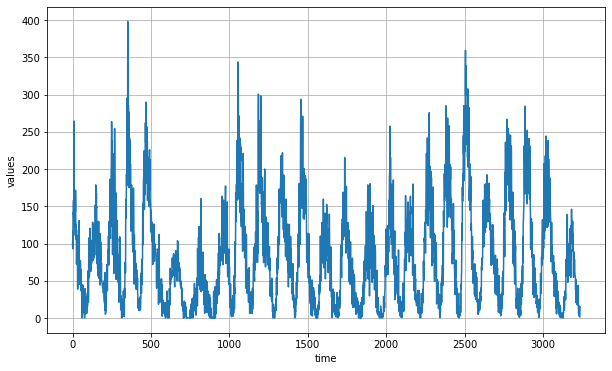

In [ ]:
time_step=[]
sunspots=[]
with open('/tmp/sunspots.csv') as sunfile:
  reader = csv.reader(sunfile,delimiter=',')
  next(reader,None)
  for col in reader:
    sunspots.append(float(col[2]))
    time_step.append(int(col[0]))
series= np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time,series)

In [ ]:
# create train and valid sets on split value:
split_point = 3000
time_train = time[:split_point] 
x_train = series[:split_point]
time_valid = time[split_point:]
x_valid = series[split_point:]

In [ ]:
window_size = 30
batch_size = 60
shuffle_buffer_size = 1000

In [ ]:
# create a windowed dataset:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer_size):
  series = tf.expand_dims(series,axis=-1)   # add an extra dimension at the end. 
  data = tf.data.Dataset.from_tensor_slices(series) # array is [[value][value2]] hence torn apart: [value][value2]
  data = data.window(window_size+1,shift=1,drop_remainder=True) # create the window as : [1 2 3 4]
                                                                                        # [2 3 4 5]
                                                                                        # [3 4 5 6] depending on window_size goes on 
  data = data.flat_map(lambda x: x.batch(window_size+1))  # flattens the above tensors into 1D
  data = data.shuffle(shuffle_buffer_size) # shuffles based on the number of shuffle size
  data = data.map(lambda x: (x[:-1],x[1:]) ) # maps to {features:label} where feature has all except last col
  
  return data.batch(batch_size).prefetch(1)  # return the data in the batch.

In [ ]:
def model_forecast(model,series,window_size):
  data = tf.data.Dataset.from_tensor_slices(series)
  data = data.window(window_size,shift=1,drop_remainder=True)
  data = data.flat_map(lambda x: x.batch(window_size))
  data = data.batch(32).prefetch(1)
  forecast = model.predict(data)  
  return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 42
batch_size = 256
train_set = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
print(train_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [ ]:
# create ultimate model:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Dense(30,activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x*400)
])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3870      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           31        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 152,573
Trainable params: 152,573
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule],verbose=1)

Epoch 1/100
12/12 [==============================] - 0s 26ms/step - loss: 109.7685 - mae: 110.2674 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 27ms/step - loss: 103.7112 - mae: 104.2099 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 24ms/step - loss: 95.3108 - mae: 95.8096 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 29ms/step - loss: 86.0486 - mae: 86.5472 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 27ms/step - loss: 76.5462 - mae: 77.0448 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 29ms/step - loss: 67.1196 - mae: 67.6179 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 58.4732 - mae: 58.9712 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 28ms/step - loss: 51.6807 - mae: 52.1784 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 0s 27ms/step - loss: 47.4507 - 

(1e-08, 0.0001, 0.0, 60.0)

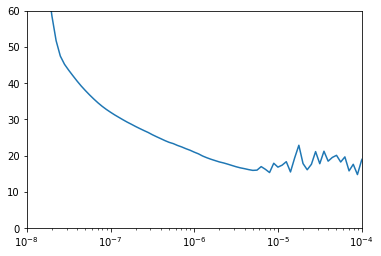

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
# create model2 using better Learning rate of 1e-5:
optimizer = tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [ ]:
history = model.fit(train_set,epochs=500)

Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 54.0103 - mae: 54.5087
Epoch 2/500
12/12 [==============================] - 0s 27ms/step - loss: 53.9996 - mae: 54.4981
Epoch 3/500
12/12 [==============================] - 0s 26ms/step - loss: 53.9908 - mae: 54.4894
Epoch 4/500
12/12 [==============================] - 0s 28ms/step - loss: 54.0234 - mae: 54.5221
Epoch 5/500
12/12 [==============================] - 0s 31ms/step - loss: 53.9977 - mae: 54.4960
Epoch 6/500
12/12 [==============================] - 0s 28ms/step - loss: 54.0098 - mae: 54.5086
Epoch 7/500
12/12 [==============================] - 0s 27ms/step - loss: 54.0079 - mae: 54.5068
Epoch 8/500
12/12 [==============================] - 0s 26ms/step - loss: 54.0237 - mae: 54.5229
Epoch 9/500
12/12 [==============================] - 0s 26ms/step - loss: 54.0021 - mae: 54.5005
Epoch 10/500
12/12 [==============================] - 0s 26ms/step - loss: 54.0334 - mae: 54.5323
Epoch 11/500
12/12 [=========

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_point - window_size:-1, -1, 0]

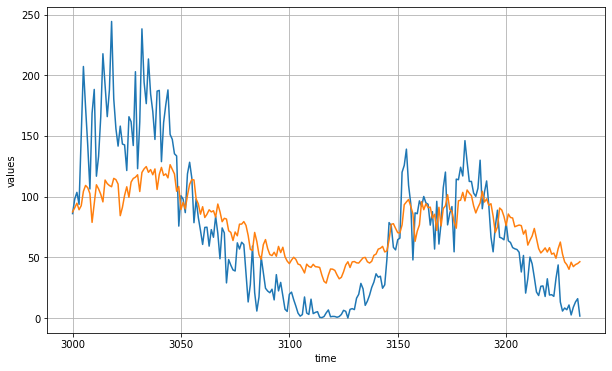

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

30.90631

<Figure size 432x288 with 0 Axes>

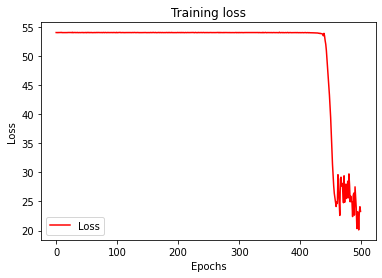

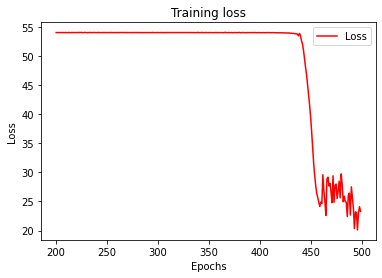

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast[:10])

[ 87.42796   90.76561   94.604576  89.17995   92.545715 104.33893
 109.209465 107.34229  102.44863   78.77953 ]
